<a href="https://colab.research.google.com/github/IRPARKS/NMML/blob/main/NMMLHW15autoencoderWK15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **Autoencoders Fundamentals:**
  - Autoencoders are a form of unsupervised learning using neural networks.
  - They compress input data into a latent representation through a bottleneck layer.
  - The bottleneck constrains information flow, forcing a compressed knowledge representation.

- **Training Process:**
  - The network minimizes reconstruction error between input and output.
  - Ideal balance: sensitive enough for accurate reconstruction, but not to memorize training data.
  - Trade-off enforced by loss function: reconstruction loss and regularization.

- **Undercomplete Autoencoder:**
  - Simplest form with limited nodes in hidden layers.
  - Learns important attributes and latent representations of input data.

- **Sparse Autoencoders:**
  - Introduces information bottleneck without reducing nodes.
  - Penalizes activations within layers to encourage sparsity.
  - Selectively activates network regions based on input data.

- **Denoising Autoencoders:**
  - Introduces noise to input data, making model robust.
  - Prevents memorization of training data by adjusting corrupted input.

- **Contractive Autoencoders:**
  - Encourages similar inputs to have similar encodings.
  - Penalizes large derivatives of hidden layer activations with respect to input.

- **Variational Autoencoders (VAE):**
  - Probabilistic approach to latent space representation.
  - Encoder outputs parameters describing a distribution for each latent dimension.
  - Decoder generates latent vector by sampling from distributions.

- **Implementation Challenges:**
  - Utilizes reparameterization trick for backpropagation.
  - Learning smooth latent representations is crucial.
  - Balancing reconstruction likelihood and KL divergence.

- **Variational Autoencoders as Generative Models:**
  - Decoder network generates new data similar to training data.
  - Allows interpolation between observations in latent space for smooth transformations.

Autoencoders
======
Based on [[this notebook]](https://github.com/smartgeometry-ucl/dl4g/blob/master/autoencoder.ipynb).

In [ ]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

Parameter Settings
-------------------


In [ ]:
latent_dims = 10
num_epochs = 250
batch_size = 128
capacity = 8
learning_rate = 1e-3
use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(data_utils.Subset(train_dataset, range(1000)), batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(data_utils.Subset(test_dataset, range(500)), batch_size=batch_size, shuffle=True)

Autoencoder Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [ ]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 20859


Train Autoencoder
--------

In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 250] average reconstruction error: 0.760877
Epoch [2 / 250] average reconstruction error: 0.734791
Epoch [3 / 250] average reconstruction error: 0.705304
Epoch [4 / 250] average reconstruction error: 0.613240
Epoch [5 / 250] average reconstruction error: 0.460513
Epoch [6 / 250] average reconstruction error: 0.361862
Epoch [7 / 250] average reconstruction error: 0.319174
Epoch [8 / 250] average reconstruction error: 0.296236
Epoch [9 / 250] average reconstruction error: 0.280574
Epoch [10 / 250] average reconstruction error: 0.269669
Epoch [11 / 250] average reconstruction error: 0.260607
Epoch [12 / 250] average reconstruction error: 0.252200
Epoch [13 / 250] average reconstruction error: 0.245043
Epoch [14 / 250] average reconstruction error: 0.237953
Epoch [15 / 250] average reconstruction error: 0.230962
Epoch [16 / 250] average reconstruction error: 0.223848
Epoch [17 / 250] average reconstruction error: 0.215789
Epoch [18 / 250] average reconstruction erro

Plot Training Curve
--------------------

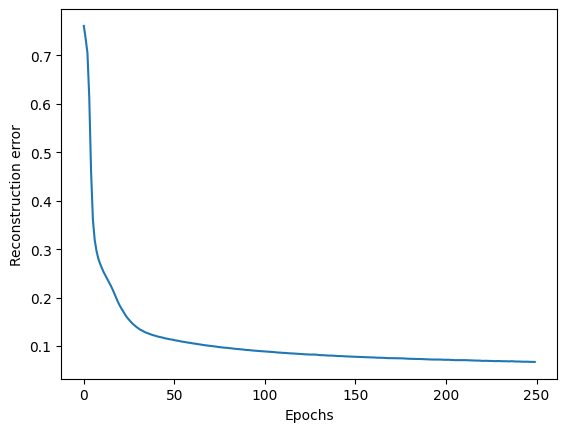

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.100200


Visualize Reconstructions
--------------------------
To enhance the performance of the autoencoder, several strategies can be employed. Firstly, meticulous hyperparameter tuning, including adjustments to learning rate, batch size, and choice of optimizer, is crucial for stable training and convergence. Secondly, refining the model architecture by adding complexity, incorporating convolutional layers, or increasing layer sizes can improve reconstruction quality. Thirdly, regularization techniques like dropout or weight decay should be implemented to prevent overfitting. Moreover, data augmentation methods can diversify training samples and enhance model robustness. Additionally, learning rate scheduling and early stopping mechanisms aid in achieving faster convergence and preventing overfitting. Ensuring proper data preprocessing and incorporating batch normalization further stabilize and accelerate training. Lastly, monitoring training progress through metrics and visualizing model outputs facilitates understanding and debugging, leading to iterative improvements in the autoencoder's effectiveness.

Original images


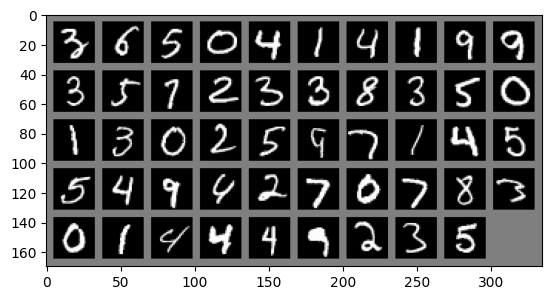

Autoencoder reconstruction:


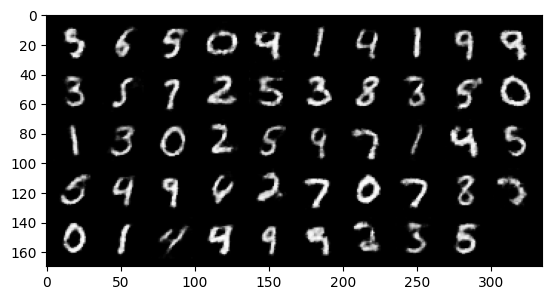

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Interpolate in Latent Space
----------------------------

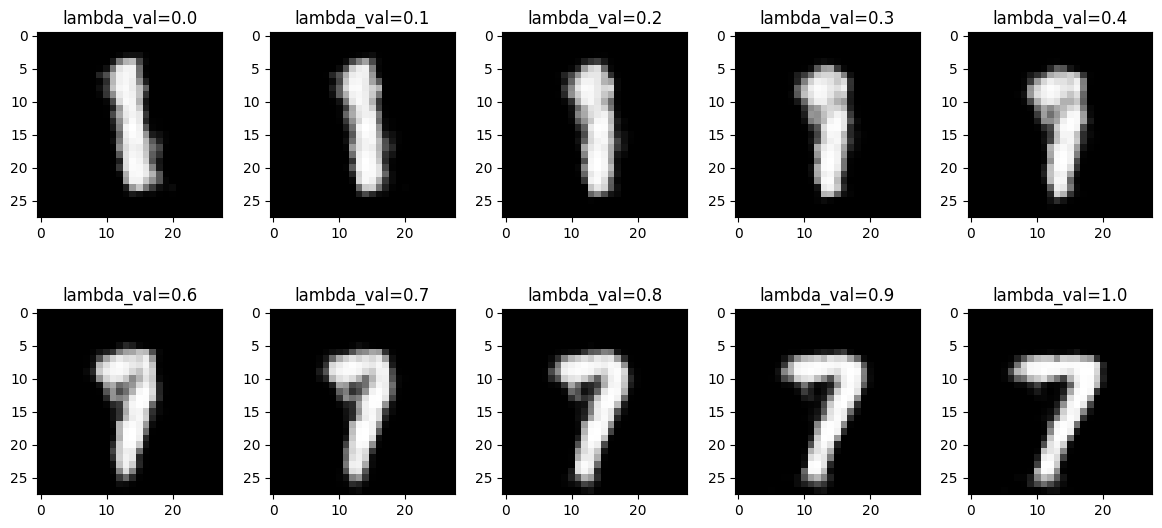

In [ ]:
autoencoder.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

    return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show()

Random Latent Vector (Autoencoder as Generator)
-------------------------------------------------

Here latent vectors are sampled randomly from a multivariate Normal distribution fit to the distribution of data latent vectors.

Due to sampling from a fitted Normal distribution, we are in the same region of latent space as the encoded data, but even so, generating new digits is hit-or-miss: many latent vectors decode to something that does not look like a digit. This means that the manifold of latent vectors that do decode to valid digits is sparse in latent space. With higher-dimensional latent spaces, the manifold gets sparser. Compare this to Variational Autoencoders that can more consistently generate valid digits from random samples.

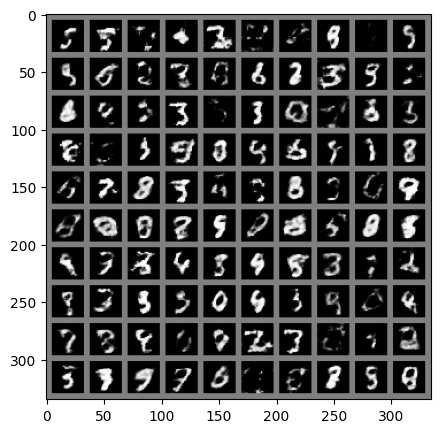

In [ ]:
autoencoder.eval()

with torch.no_grad():
    # approx. fit a multivariate Normal distribution (with diagonal cov.) to the latent vectors of a random part of the test set
    images, labels = next(iter(test_dataloader))
    images = images.to(device)
    latent = autoencoder.encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims)*std + mean

    # reconstruct images from the latent vectors
    latent = latent.to(device)
    img_recon = autoencoder.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

This approach can produce diverse samples, the quality may be limited by the complexity and representational capacity of the autoencoder's latent space. Here, I saw an improvement up to a certain point with diminishing returns as we see we lose values in this current run.

On the other hand, a Variational Autoencoder (VAE) might be a better choice for generating new observations due to its probabilistic nature and more structured latent space. In a VAE, the encoder outputs parameters describing the distribution of each latent dimension, typically assumed to follow a multivariate Gaussian distribution. This enables more controlled and structured generation of new samples by sampling from the learned distribution. Additionally, VAEs are trained to optimize a variational lower bound on the log-likelihood of the data, which encourages smoother and more coherent sampling from the latent space.